# Classifying emotions in movie dialogue using Watson NLP - pre-trained models

This notebook demonstrates how to classify emotions in tweets using Watson NLP python library

### What you'll learn in this notebook
Watson NLP offers so-called blocks for various NLP tasks. This notebook shows:

- **Syntax analysis** with the _Syntax block_ for English (`syntax_izumo_en_stock`). This block performs tokenization, lemmatization, parts of speech tagging, and dependency parsing on raw input documents so that custom models can properly classify documents.
- **Emotion classification** with the _Ensemble emotion workflow_ (`ensemble_classification-wf_en_emotion-stock`) and the _Aggregated emotion workflow_ (`aggregated_classification-wf_en_emotion-stock`). These model workflow classify text into five emotions: "sadness", "joy", "anger", "fear", "disgust".

## Table of Contents

1.  [Before you start](#beforeYouStart)
1.	[Data Loading](#loadData)
1.  [Data Processing](#dataProcessing)
    1. [Data formatting](#dataFormat)
    1. [Train test split](#trainTestSplit) 
1. [Running pretrained models](#pretrainedOOTB)
    1. [Ensemble emotion model](#ensemble)
    1. [Aggregated emotion workflow](#aggregated)
1. [Exploring document level token level predictions](#words)
1.  [Summary](#summary)

<a id="beforeYouStart"></a>
## 1. Before you start

<div class="alert alert-block alert-danger">
<b>Stop kernel of other notebooks.</b></div>

**Note:** If you have other notebooks currently running with the _Default Python 3.8 + Watson NLP XS_ environment, **stop their kernels** before running this notebook. All these notebooks share the same runtime environment, and if they are running in parallel, you may encounter memory issues. To stop the kernel of another notebook, open that notebook, and select _File > Stop Kernel_.

<div class="alert alert-block alert-warning">
<b>Set Project token.</b></div>

Before you can begin working on this notebook in Watson Studio in Cloud Pak for Data as a Service, you need to ensure that the project token is set so that you can access the project assets via the notebook.

When this notebook is added to the project, a project access token should be inserted at the top of the notebook in a code cell. If you do not see the cell above, add the token to the notebook by clicking **More > Insert project token** from the notebook action bar.  By running the inserted hidden code cell, a project object is created that you can use to access project resources.

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)

<div class="alert alert-block alert-info">
<b>Tip:</b> Cell execution</div>

Note that you can step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.

<span style="color:blueviolet">Begin by importing and initializing some helper libs that are used throughout the notebook.</span>


In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import watson_nlp
import watson_nlp.data_model as dm

from sklearn.model_selection import train_test_split

from watson_core.toolkit import fileio
from watson_core.toolkit.quality_evaluation import QualityEvaluator, EvalTypes

from watson_nlp.blocks.classification.bert import BERT
from watson_nlp.blocks.classification.cnn import CNN
from watson_core.data_model.streams.resolver import DataStreamResolver
from watson_core.data_model.streams.resolver import DataStream
from watson_nlp.blocks.classification.svm import SVM
from watson_nlp.blocks.vectorization.tfidf import TFIDF

In [3]:
pd.set_option('display.max_colwidth', 0)

<span style="color:maroon">Printing either `block_models` or `workflow_models` will display a list of pretrained models available in the current version of Watson NLP</span>

In [4]:
block_models = watson_nlp.get_models().get_alias_models()
workflow_models = watson_nlp.get_workflows().get_alias_models()

<a id="loadData"></a>
## 2. Data Loading

The dataset contains over seven thousand quotations from tweets. The labeled emotions in the dataset are "anger", "sadness", "fear", "joy", and "disgust". Because some quotations have multiple sentences, they can be regarded as documents. The dataset is available internally at [Github Repo](https://github.ibm.com/hcbt/Watson-NLP/blob/main/Emotion-Classification/emotion_tweets.csv). The original source of this dataset is from [Kaggle](https://www.kaggle.com/datasets/anjaneyatripathi/emotion-classification-nlp?select=emotion-labels-train.csv) with a CC0: Public Domain license.
<br><br>
Any other emotion classification dataset may be used in substitution for the workflow outlined in this notebook.

Data format:
- .csv file that is loaded as a Pandas DataFrame with two columns, `text` and `label`

Data dictionary:
- text: string; text of tweets; this will be used as the input for models
- label: string; emotion class labels; this will be the what the model is trying to accurately predict

<span style="color:blue">The previously inserted project access token will be used to import datasets from the Project Data Assets. The most commonly imported file formats are .csv and .json.</span>

<div class="alert alert-block alert-danger">
<b>Insert dataset</b></div>

<span style="color:red">!!! Before you can begin working on this notebook, you need to insert the data into the notebook. !!!</span>

1. Create a new cell by clicking on **Insert** menu and then selecting **Insert Cell Below** or **Esc+B** shortcut key
1. Select the code cell shown in the image below by clicking it.
1. Ensure you place the cursor below the commented line.
1. Click the Find and add data icon (01/00) on the top right corner. 
1. Choose the Files tab, and pick the your dataset .csv; in this case `emotion-tweets.csv` file. 
1. Click Insert to code and choose pandas DataFrame.
1. Rename the dataframe from `df_data_1` to `df`

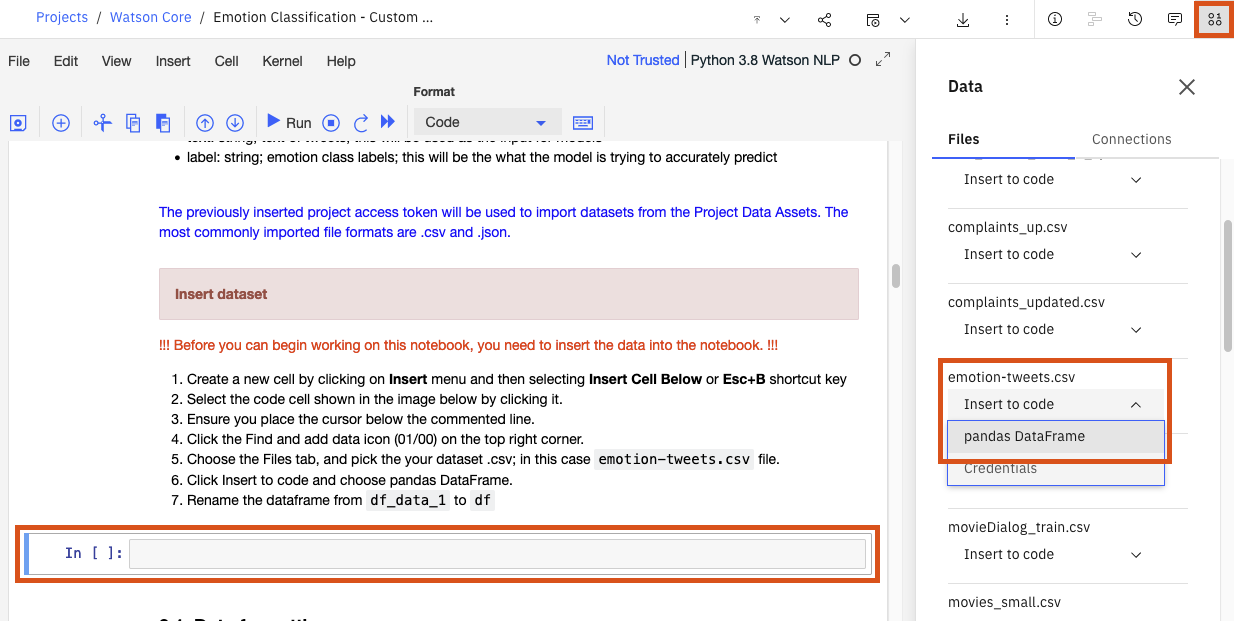

<a id="dataProcessing"></a>
## 3. Data Processing

<a id="dataFormat"></a>
### 3.1. Data formatting

<span style="color:blue">Data prepared for Watson NLP models need to be formatted in such a way that there is a `text` feature column and a `labels` label column. The `labels` column needs have type `list`.</span>

In [6]:
def convertToList(x):
    return [x]

In [7]:
df['label'] = df['label'].apply(convertToList)
df = df.rename(columns={'label':'labels'})

<a id="trainTestSplit"></a>
### 3.2. Train Test Split

<div class="alert alert-block alert-info">
<b>Tip:</b> If you want to carry out emotion analysis on any other dataset, you should first upload the dataset into the project and then update the name of the file in the next cell</div>
<br>

<span style="color:blue">The data will be split into an 80/20 train-test split using sklearn and then exported into JSON format for the Watson NLP models to consume. Additionally, the column headers will be renamed to the expected `text` and `labels` names, with the labels having type list.</span>

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [9]:
df_train.to_json('df_train.json', orient='records')
df_test.to_json('df_test.json', orient='records')

In [10]:
df_train

,text,labels,source
3358,Where am I gonna start?,[neutral],MovieDialog
1878,You're insane or you think I am.,[anger],MovieDialog
536,"Oh, that's 'cause we both play doohickies. I met him in a box car a couple o' years ago. I was foolin' around with my harmonica and he comes over and joins in. I haven't been able to shake him since.",[fear],MovieDialog
797,Was it something that happened at school?,[fear],MovieDialog
1565,"A dirtbag behind the counter holding a sawed-off. A Berretta nine millimeter in his belt. A female hostage, red dress, on the floor in front of the cereal display. Male hostage, jeans and blue checked shirt, three feet to her right. Another male hostage, white pants, green shirt, Nikes, laying in front of the magazine rack. A female dirtbag with a gun under her shirt, sitting against the beer cooler, trying to pass herself off as a hostage, and there's a special on toilet-paper, four for a buck twenty-nine.",[anger],MovieDialog
...,...,...,...
723,"Yes. It would be a pity, wouldn't it? Call him back!",[sadness],MovieDialog
853,Nicky? Oh my God. Stay right there.,[fear],MovieDialog
2463,Here's one by a man that's very much alive.,[neutral],MovieDialog
2379,Thank you very much. Thank you my dear. Girl bows and exits to loud applause.,[happiness],MovieDialog


<a id="pretrainedOOTB"></a>
## 4. Running pretrained models
<span style="color:blue">Watson NLP has two pretrained/prebuilt emotion classificaiton models using the workflow system. 
The following examples will use *\"Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me.\"* as a single input test with the expected label to be *\"joy\"*.</span>

<a id="ensemble"></a>
### Ensemble emotion model
<br>
<span style="color:blue">Ensemble emotion model will perform document emotion classification. [Docs](https://pages.github.ibm.com/ai-foundation/watson-nlp-documentation/workflow_emotion_classification.html)</span>

In [11]:
# Load the Emotion workflow model for English
ensemble_emotion_model = watson_nlp.load(watson_nlp.download('ensemble_classification-wf_en_emotion-stock'))

<span style="color:blueviolet">The result of the Ensemble model returns a list of dictionaries that indicate each label and its confidence score. The highest confidence score deems the label of prediction.</span>

In [12]:
# Run the Emotion model on a single document
ensemble_emotion_result = ensemble_emotion_model.run("Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me. ")
print(ensemble_emotion_result)

{
  "classes": [
    {
      "class_name": "joy",
      "confidence": 0.520251523364674
    },
    {
      "class_name": "sadness",
      "confidence": 0.13437655658432934
    },
    {
      "class_name": "anger",
      "confidence": 0.030973352040305283
    },
    {
      "class_name": "fear",
      "confidence": 0.023922530189972323
    },
    {
      "class_name": "disgust",
      "confidence": 0.01345159203717203
    }
  ],
  "producer_id": {
    "name": "Voting based Ensemble",
    "version": "0.0.1"
  }
}


<span style="color:blueviolet">The Ensemble model also has the `model.evaluate_quality()` function, which allows the evaluation of an entire test set. The result returns a dictionary of dictionaries that map each label to its confusion matrix, precision and recall, and f1 score.</span>

In [13]:
test_data_file = "df_test.json"

quality_report = ensemble_emotion_model.evaluate_quality(test_data_file)
print(json.dumps(quality_report, indent=4))

{
    "per_class_confusion_matrix": {
        "anger": {
            "true_positive": 169,
            "true_negative": 0,
            "false_positive": 56,
            "false_negative": 126,
            "precision": 0.7511111111111111,
            "recall": 0.5728813559322034,
            "f1": 0.65
        },
        "neutral": {
            "true_positive": 0,
            "true_negative": 0,
            "false_positive": 0,
            "false_negative": 287,
            "precision": 0,
            "recall": 0.0,
            "f1": 0
        },
        "joy": {
            "true_positive": 0,
            "true_negative": 0,
            "false_positive": 262,
            "false_negative": 0,
            "precision": 0.0,
            "recall": 0,
            "f1": 0
        },
        "sadness": {
            "true_positive": 61,
            "true_negative": 0,
            "false_positive": 194,
            "false_negative": 40,
            "precision": 0.23921568627450981,
            

Based on the micro precision, recall, and f1 score, this Ensemble model did not perform well on our test data. However hyperparameter tuning of the pre-trained model may improve its performance.
<br><br>
*The micro metrics are taken here instead of the macro metrics because of the class imbalance in the data.

<span style="color:blue">By parsing out the results of the model runs, we can visualize the difference between predicted labels and actual labels.</span>

In [14]:
def run_emotion(text):
    emotion_result = ensemble_emotion_model.run(text)
    emo_dict = {emo.class_name:emo.confidence for emo in emotion_result.classes}
    return emo_dict

In [15]:
test_df = pd.read_json(test_data_file)
test_df['label'] = test_df['labels'].str[0]
test_df['label'] = test_df['label'].replace({'happiness':'joy'})

In [16]:
output = []
for line in test_df['text']:
    output.append([line, run_emotion(line)])

In [17]:
emotion_df = pd.DataFrame(output, columns=['text', 'emotions'])
emotion_df = pd.concat([emotion_df, emotion_df["emotions"].apply(pd.Series)], axis=1)
emotion_df = emotion_df.drop(['emotions'], axis=1)
emotion_df['highest_emotion'] = emotion_df[['joy', 'anger', 'sadness', 'fear', 'disgust']].idxmax(axis=1)

Text(0.5, 1.0, 'Test dataset labels')

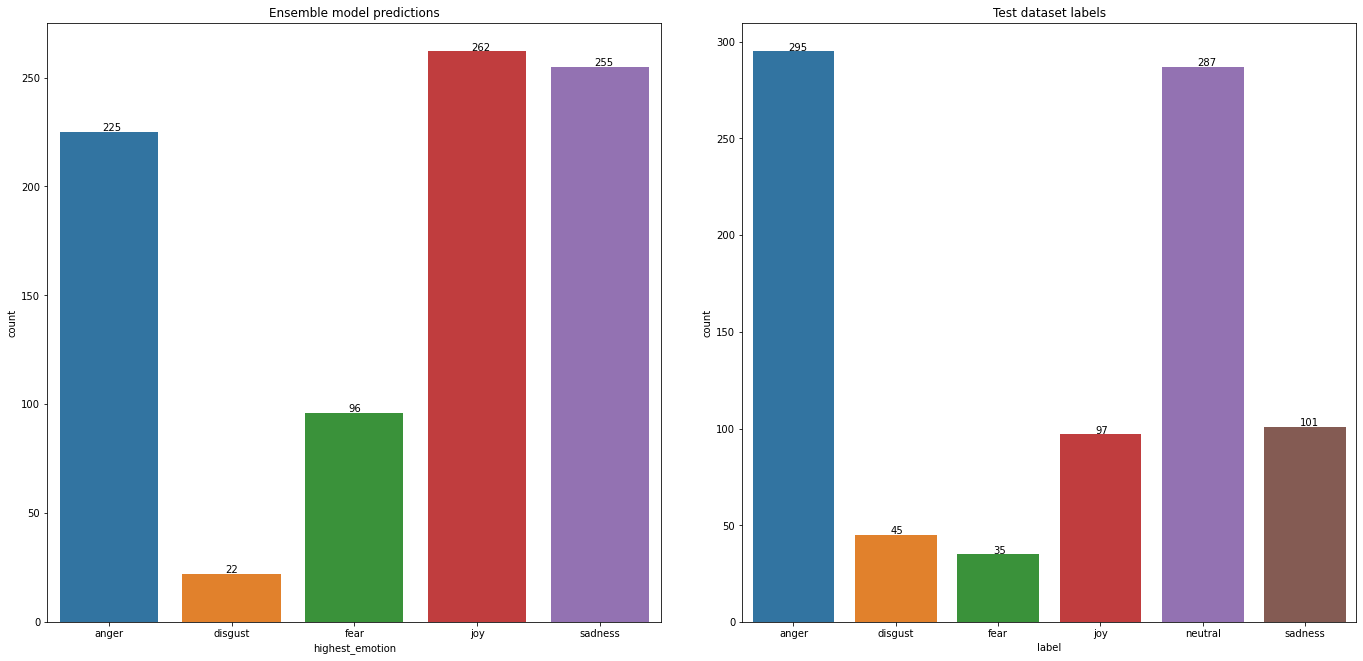

In [18]:
figure, ax = plt.subplots(ncols=2, figsize=(20,10))
figure.tight_layout(pad=5)
sns.countplot(x=emotion_df['highest_emotion'],  data=emotion_df['highest_emotion'], order=emotion_df['highest_emotion'].value_counts().sort_index().index, ax=ax[0])
for p, label in zip(ax[0].patches, emotion_df['highest_emotion'].value_counts().sort_index()): 
    ax[0].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[0].set_title('Ensemble model predictions')

sns.countplot(x=test_df["label"],  data=test_df["label"], order=test_df["label"].value_counts().sort_index().index, ax=ax[1])
for p, label in zip(ax[1].patches, test_df["label"].value_counts().sort_index()):   
    ax[1].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[1].set_title('Test dataset labels')

<a id="aggregated"></a>
### Aggregated emotion workflow
Aggregated emotion model has the capability of specifying target words in addition to document emotion classification. [Docs](https://pages.github.ibm.com/ai-foundation/watson-nlp-documentation/workflow_emotion_aggregated.html)

In [19]:
# Load the Emotion workflow model for English
aggregated_emotion_model = watson_nlp.load(watson_nlp.download('aggregated_classification-wf_en_emotion-stock'))

<span style="color:blue">By defining a target span of indices with the `target_mentions` parameter, the Aggregated model can predict emotion on exact segments of the input. </span>
<br><br>
<span style="color:blueviolet">Similarly to the Ensemble model, the Aggregated model returns a list of dictionaries that indicate each label and its confidence score. As before, the highest confidence score deems the label of prediction. 
The first dictionary in the result is the prediction of the overall input; the subsequent dictionaries with a \"target\" key is the prediction of each targeted text span.</span>

In [20]:
# span targets a section of the document given indices
target_mentions = dm.TargetMentionsPrediction([dm.TargetMentions([(7, 16)]), dm.TargetMentions([(28, 66)])])

aggregated_emotion_result_span = aggregated_emotion_model.run("Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me. ", 
                                   target_mentions=target_mentions)

print(aggregated_emotion_result_span)

{
  "emotion_predictions": [
    {
      "emotion": {
        "anger": 0.014531953677202513,
        "disgust": 0.015678834170103073,
        "fear": 0.004446345653956418,
        "joy": 0.9617643175703107,
        "sadness": 0.04595572027293119
      },
      "target": "sweet boy",
      "emotion_mentions": [
        {
          "span": {
            "begin": 0,
            "end": 17,
            "text": "Such a sweet boy."
          },
          "emotion": {
            "anger": 0.014531953677202513,
            "disgust": 0.015678834170103073,
            "fear": 0.004446345653956418,
            "joy": 0.9617643175703107,
            "sadness": 0.04595572027293119
          }
        }
      ]
    },
    {
      "emotion": {
        "anger": 0.16141723276990833,
        "disgust": 0.016278604327729256,
        "fear": 0.08282793606772569,
        "joy": 0.0715819208910971,
        "sadness": 0.2009543270775766
      },
      "target": "much thought and careful consideration",
     

<span style="color:blueviolet">By defining a target text phrase with the `target_phrases` parameter, the Aggregated model can predict emotion on exact words and phrases in the input. 
The result is just like the previous return, but this time with the \"target\" key having the targeted phrase.</span>

In [21]:
# text targets a section of the document given phrases
target_phrases = ['sweet boy', 'careful consideration']

aggregated_emotion_result_text = aggregated_emotion_model.run("Such a sweet boy. But after much thought and careful consideration, I've decided that the ruler for the next ten thousand years is going to have to be... me. ", 
                                   target_phrases=target_phrases)

print(aggregated_emotion_result_text)

{
  "emotion_predictions": [
    {
      "emotion": {
        "anger": 0.014531953677202513,
        "disgust": 0.015678834170103073,
        "fear": 0.004446345653956418,
        "joy": 0.9617643175703107,
        "sadness": 0.04595572027293119
      },
      "target": "sweet boy",
      "emotion_mentions": [
        {
          "span": {
            "begin": 0,
            "end": 17,
            "text": "Such a sweet boy."
          },
          "emotion": {
            "anger": 0.014531953677202513,
            "disgust": 0.015678834170103073,
            "fear": 0.004446345653956418,
            "joy": 0.9617643175703107,
            "sadness": 0.04595572027293119
          }
        }
      ]
    },
    {
      "emotion": {
        "anger": 0.16141723276990833,
        "disgust": 0.016278604327729256,
        "fear": 0.08282793606772569,
        "joy": 0.0715819208910971,
        "sadness": 0.2009543270775766
      },
      "target": "careful consideration",
      "emotion_mention

<span style="color:blue">By parsing out the results of the model runs, we can visualize the difference between predicted labels and actual labels.</span>

In [22]:
def run_emotion_2(text):
    # run the emotion model on the result of the syntax analysis
    emotion_result = aggregated_emotion_model.run(text, document_emotion=True)
    
    document_emotion = emotion_result.to_dict()['emotion_predictions'][0]['emotion']
    mention_emotion = [(sm['span']['text'], sm['emotion']) for sm in emotion_result.to_dict()['emotion_predictions'][0]['emotion_mentions']]
    return (document_emotion, mention_emotion)

# Helper method to create a new dataframe with the corresponding emotion
def create_emotion_dataframe(df):
    emotion = df['text'].apply(lambda text: run_emotion_2(text))
    emotion_df = pd.DataFrame.from_records(emotion, columns=('Document emotion', 'Mention emotion'))
    return emotion_df

In [23]:
# this will take some time
emotion_2_df = create_emotion_dataframe(test_df)

In [24]:
document_emotion_df = df[['text']].merge(pd.DataFrame(emotion_2_df['Document emotion'].values.tolist()), 
                                          how='left', 
                                          left_index=True, 
                                          right_index=True)
document_emotion_df['highest_emotion'] = document_emotion_df[['joy', 'anger', 'sadness', 'fear', 'disgust']].idxmax(axis=1)

Text(0.5, 1.0, 'Test dataset labels')

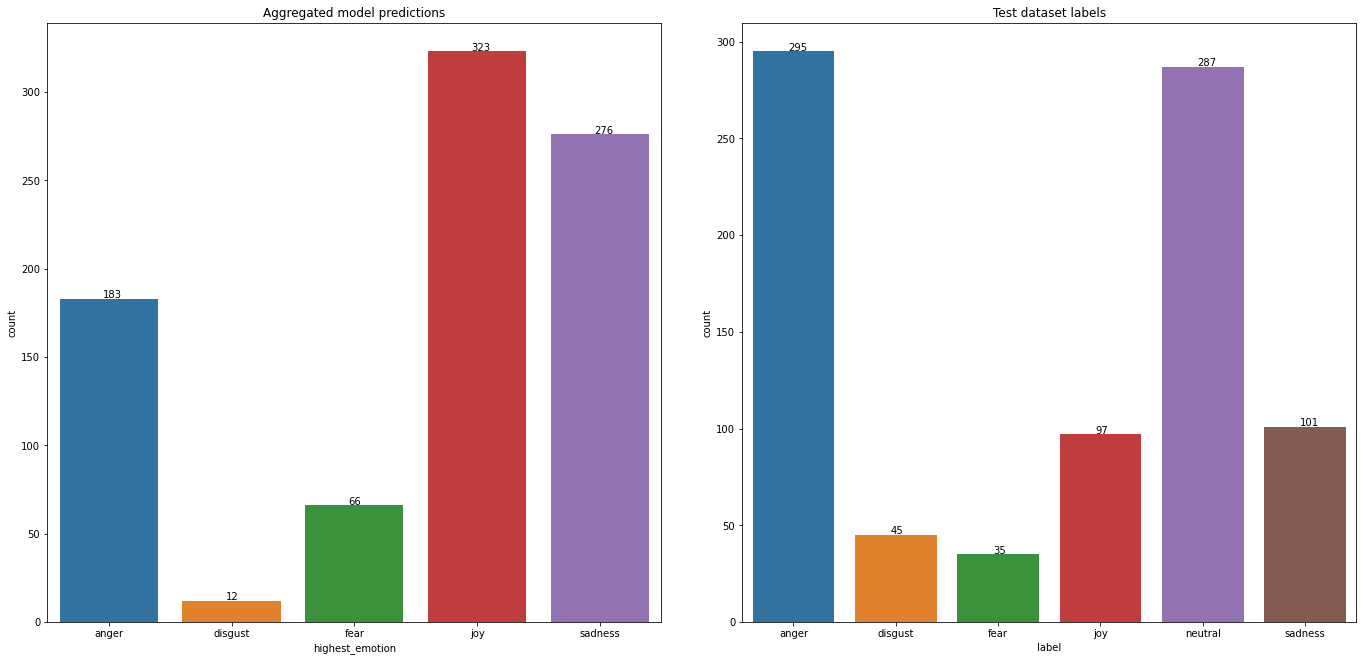

In [25]:
figure, ax = plt.subplots(ncols=2, figsize=(20,10))
figure.tight_layout(pad=5)
sns.countplot(x=document_emotion_df["highest_emotion"],  data=document_emotion_df['highest_emotion'], order=document_emotion_df["highest_emotion"].value_counts().sort_index().index, ax=ax[0])
for p, label in zip(ax[0].patches, document_emotion_df["highest_emotion"].value_counts().sort_index()):   
    ax[0].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[0].set_title('Aggregated model predictions')

sns.countplot(x=test_df["label"],  data=test_df["label"], order=test_df["label"].value_counts().sort_index().index, ax=ax[1])
for p, label in zip(ax[1].patches, test_df["label"].value_counts().sort_index()):   
    ax[1].annotate(label, (p.get_x()+0.35, p.get_height()+0.5))
ax[1].set_title('Test dataset labels')

<a id="words"></a>
## 5. Exploring document level token level predictions
<span style="color:blue">The cells that follow are an exploration of the Aggregated model with regard to document level and token level predictions. The model returns will be constructed into dataframes to better view results.</span>

In [26]:
# set the emotion model as the aggregated out of the box model because of its target mention capability
emotion_model = aggregated_emotion_model

In [27]:
def extract_emotion(text):
    # run the emotion model on the result of the syntax analysis
    emotion_result = emotion_model.run(text, document_emotion=True)
    
    document_emotion = emotion_result.to_dict()['emotion_predictions'][0]['emotion']
    mention_emotion = [(sm['span']['text'], sm['emotion']) for sm in emotion_result.to_dict()['emotion_predictions'][0]['emotion_mentions']]
    return (document_emotion, mention_emotion)

# Helper method to create a new dataframe with the corresponding emotion
def create_emotion_dataframe(df):
    emotion = df['text'].apply(lambda text: extract_emotion(text))
    emotion_df = pd.DataFrame.from_records(emotion, columns=('Document emotion', 'Mention emotion'))
    return emotion_df

In [34]:
# this will take some time
emotion_df = create_emotion_dataframe(df)

<span style="color:blue">In the context of the dataset, each row is a different and unrelated movie dialog from the entire dataset (before train-test split).</span>

In [35]:
document_emotion_df = df[['text']].merge(pd.DataFrame(emotion_df['Document emotion'].values.tolist()), 
                                          how='left', 
                                          left_index=True, 
                                          right_index=True)
document_emotion_df

,text,anger,disgust,fear,joy,sadness
0,"No... sort of. Man, she could be cool, but all she does is get wrecked and do all the guys. She's blowin' them in the parking lot.",0.091589,0.101249,0.127507,0.179821,0.280981
1,Poker sounds great. When do you play?,0.070759,0.047147,0.089574,0.533756,0.179207
2,Washington! Always discussing the problems of Washington. Nobody ever thinks of the State--and my problems! I *will* tell Jim Taylor. It's high *time* I told him a thing or two!,0.222626,0.040641,0.185320,0.173301,0.250626
3,"You know, Julie, even if this works - which it probably won't - that stuff is tricky. You don't know what it'll do to his brain.",0.130315,0.030532,0.311909,0.043280,0.298986
4,"David, please be rational. Let's go to Dr. Hirsch.",0.048054,0.017707,0.472761,0.230007,0.088004
...,...,...,...,...,...,...
4294,"You can't have nothing, Jill. We need lunch. Mr. Pizza?",0.103425,0.030539,0.064858,0.386445,0.150501
4295,"You can't help me, man.",0.152057,0.050473,0.113592,0.105413,0.468593
4296,You don't know. I'm sorry. I was desperate. That's not me. I shot a cop. Can you imagine what they'll do to me when I got to prison?,0.157979,0.103479,0.144720,0.139576,0.323363
4297,You just try getting a dangerous organism past ICC quarantine. Section 22350 of the Commerce Code.,0.054277,0.058827,0.090908,0.142387,0.459514


<span style="color:blueviolet">Each document (dialog) is broken down into tokenized \"sentences\" called `Mention`. The dataframe displays confidence scores for each Mention in the dialog.</span>

In [36]:
mention_emotion_df = df[['text']].merge(emotion_df['Mention emotion'], 
                                        how='left', 
                                        left_index=True, 
                                        right_index=True).explode('Mention emotion')
mention_emotion_df[['Mention', 'Mention emotion']] = pd.DataFrame(mention_emotion_df['Mention emotion'].values.tolist(), 
                                                                  index=mention_emotion_df.index)
mention_emotion_df = mention_emotion_df.reset_index(drop=True)
mention_emotion_df = mention_emotion_df.merge(pd.DataFrame(mention_emotion_df['Mention emotion'].values.tolist()), 
                                              how='left', 
                                              left_index=True, 
                                              right_index=True).drop(['Mention emotion'], 
                                                                     axis=1).reset_index(drop=True)
mention_emotion_df

,text,Mention,anger,disgust,fear,joy,sadness
0,"No... sort of. Man, she could be cool, but all she does is get wrecked and do all the guys. She's blowin' them in the parking lot.",No...,0.168124,0.058029,0.133240,0.059511,0.531680
1,"No... sort of. Man, she could be cool, but all she does is get wrecked and do all the guys. She's blowin' them in the parking lot.",sort of.,0.060752,0.045201,0.098103,0.174564,0.390191
2,"No... sort of. Man, she could be cool, but all she does is get wrecked and do all the guys. She's blowin' them in the parking lot.","Man, she could be cool, but all she does is get wrecked and do all the guys.",0.079805,0.029354,0.184642,0.313404,0.096801
3,"No... sort of. Man, she could be cool, but all she does is get wrecked and do all the guys. She's blowin' them in the parking lot.",She's blowin' them in the parking lot.,0.057676,0.272411,0.094043,0.171805,0.105253
4,Poker sounds great. When do you play?,Poker sounds great.,0.020171,0.008876,0.025652,0.961723,0.172872
...,...,...,...,...,...,...,...
8219,You don't know. I'm sorry. I was desperate. That's not me. I shot a cop. Can you imagine what they'll do to me when I got to prison?,I shot a cop.,0.244811,0.326208,0.109765,0.048646,0.118646
8220,You don't know. I'm sorry. I was desperate. That's not me. I shot a cop. Can you imagine what they'll do to me when I got to prison?,Can you imagine what they'll do to me when I got to prison?,0.218020,0.085483,0.211432,0.026062,0.175031
8221,You just try getting a dangerous organism past ICC quarantine. Section 22350 of the Commerce Code.,You just try getting a dangerous organism past ICC quarantine.,0.064820,0.108531,0.158357,0.024554,0.291375
8222,You just try getting a dangerous organism past ICC quarantine. Section 22350 of the Commerce Code.,Section 22350 of the Commerce Code.,0.043734,0.009124,0.023458,0.260219,0.627653


## 6. Summary

<span style="color:blue">This notebook shows you how to use the Watson NLP library and how quickly and easily you can get started with Watson NLP by running the pretrained models for emotion analysis.

Please note that this content is made available for internal use in IBM to foster IBM Embeddable AI technology adoption. The content is pending patent with USPTO and protected under US Patent Laws. For sharing this content outside of IBM, Build Labs will use release process. Please contact Kunal Sawarkar (kunal@ibm.com) for details.
Developed by Build Labs Team, IBM Cloud & Cognitive.
 - Data Scientist - Shivam Raj Solanki (Shivam.raj.solanki@ibm.com)
 - Data Scientist - Christopher Chen (christopherchen@ibm.com)

Copyright (c) 2022 IBM Corporation